In [ ]:
import gdown
!gdown 1jFhLYhL5Eq5RAFZvYyteud2Khf7V3daP  # '10_dortmunds_means.csv'
# !gdown 1vAxLbYphl_RyBShByZTS0hYtE6HYM9Ym
!gdown 1lMUhUsD4x3-Knc1uYcsGVwSj1gZJsxyI  # concat_design_df_pfb
!gdown 1VPJzUBDLX4u7N8GQgZCffzBW3rNd1O_m  # concat_design_df_mean
!gdown 1u56v_3lV0_jA2uA32E2qtAlpbZW7aMXj # BrainAge_v1.0_ohneDKA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dortmunds_pfb  = pd.read_csv('concat_design_df_pfb.csv').fillna(0)
dortmunds_mean = pd.read_csv('concat_design_df_mean.csv').fillna(0)
    #'10_dortmunds_means.csv')
print(dortmunds_pfb.shape, dortmunds_mean.shape)

# dortmunds = dortmunds_pfb.merge(
#     dortmunds_mean,
#     on=['vp_id', 'epoch', 'sex'],
#     how='inner'
# )

def age(val):
  if val in range(20, 30):
    return 20
  if val in range(30, 40):
    return 30
  if val in range(40, 50):
    return 40
  if val in range(50, 60):
    return 50
  if val in range(60, 70):
    return 60

dort_metadata = pd.read_csv('BrainAge_v1.0_ohneDKA.csv', sep=';').rename(
    columns={'VP_ID': 'vp_id'})
dort_metadata['age'] = dort_metadata['age_jittered'].apply(age)

dortmunds = dortmunds_pfb.merge(
    dort_metadata[['vp_id', 'age', 'age_jittered']],
    on=['vp_id'],
    how='left'
)
print(dortmunds.shape)

(45271, 323) (45271, 67)
(45271, 325)


In [ ]:
y_sex = dortmunds['sex'].replace('m', 1).replace('w', 0)
y_subj = dortmunds['vp_id']
y_age = dortmunds['age']
X = dortmunds_pfb.drop(columns=['sex', 'vp_id', 'epoch'])  # dortmunds
# print(X.columns)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
dortmunds['sex'] = dortmunds['sex'].replace('m', 1).replace('w', 0)
dortmunds[['vp_id', 'sex', 'age', 'age_jittered']].describe(include='all').T

count unique    top freq       mean       std   min   25%  \
vp_id           45271    221  VP001  205        NaN       NaN   NaN   NaN   
sex           45271.0    NaN    NaN  NaN   0.353206  0.477971   0.0   0.0   
age           45271.0    NaN    NaN  NaN  24.301871  4.951076  20.0  20.0   
age_jittered  45271.0    NaN    NaN  NaN  28.431689  4.624759  20.0  25.0   

               50%   75%   max  
vp_id          NaN   NaN   NaN  
sex            0.0   1.0   1.0  
age           20.0  30.0  30.0  
age_jittered  28.0  32.0  38.0

In [ ]:
kmeans = KMeans(
    init="random", #'k-means++',#
    n_clusters=2,  # two sexes
    n_init=10,
    max_iter=1000,
    random_state=42)

In [ ]:
%%time
kmeans.fit(scaled_X)
y_predict = kmeans.labels_
answer = pd.DataFrame()
answer['subj'] = y_subj
answer['sex']  = y_sex
answer['y_pred'] = y_predict

CPU times: user 12.3 s, sys: 79.2 ms, total: 12.3 s
Wall time: 10.4 s


In [ ]:
# kmeans.fit(scaled_X)
# y_predict = kmeans.labels_
# answer = pd.DataFrame()
# answer['subj'] = y_subj
# answer['sex']  = y_sex
# answer['y_pred'] = y_predict

In [ ]:
for i in answer.y_pred.unique()[:10]:
  cluster_size = answer[answer.y_pred == i].shape[0]
  print(i, ' - clust size=', cluster_size,
        ' : subj=', answer[answer.y_pred == i]['subj'].unique(),
        ' : sex=', answer[answer.y_pred == i]['sex'].unique())

In [ ]:
import plotly.express as px

pca = PCA()
components = pca.fit_transform(scaled_X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=y_subj
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
PCA_df = pd.DataFrame(components)
PCA_df['id'] = y_subj
PCA_df['sex'] = y_sex
PCA_df.to_csv('/content/drive/MyDrive/Science/PCA_result.csv')

In [ ]:
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=y_sex
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=y_predict
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=y_age
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
pca = PCA()
components = pca.fit_transform(scaled_X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=y_subj
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
# ! pip uninstall umap -y
! pip install umap-learn

(45271, 2)


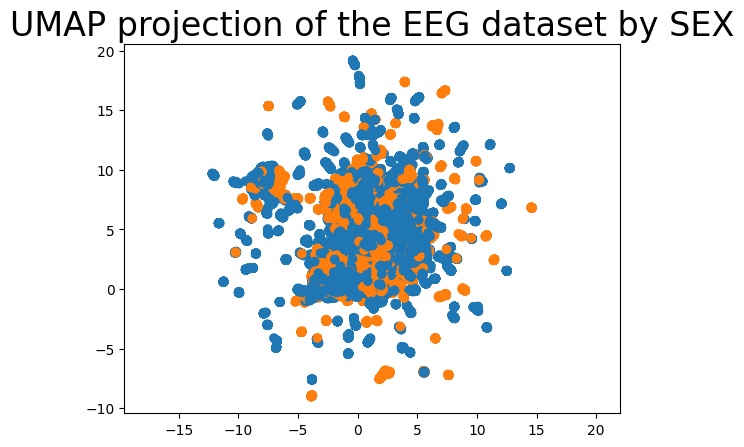

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(scaled_X)
print(embedding.shape)

# subj_dict = dict()
# for val, key in enumerate(y_subj.unique()):
#   subj_dict[key] = val

# sex_dict = {1: 1, }

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x]
       for x in y_sex
      #  for x in y_subj.map(subj_dict)
      ]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the EEG dataset by SEX', fontsize=24);

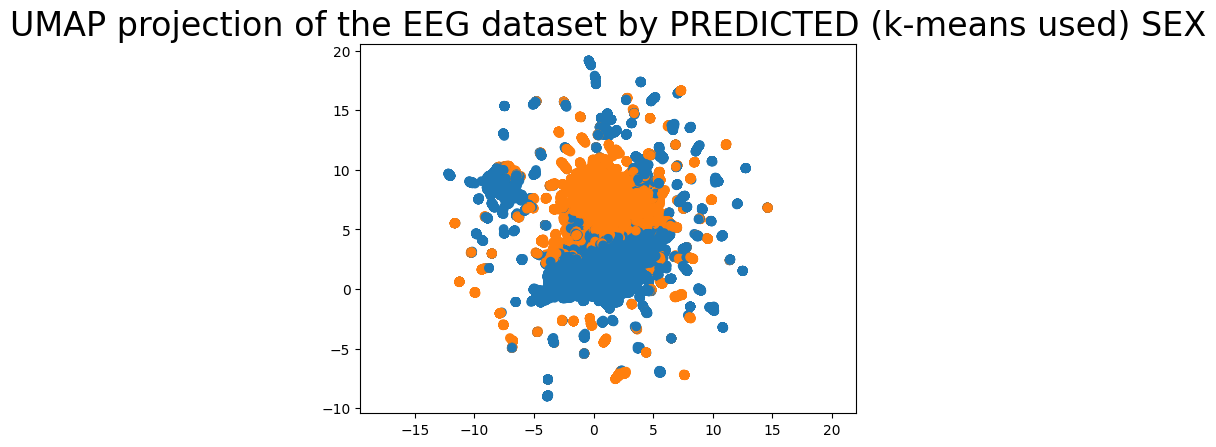

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x]
       for x in y_predict
      ]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the EEG dataset by PREDICTED (k-means used) SEX', fontsize=24);

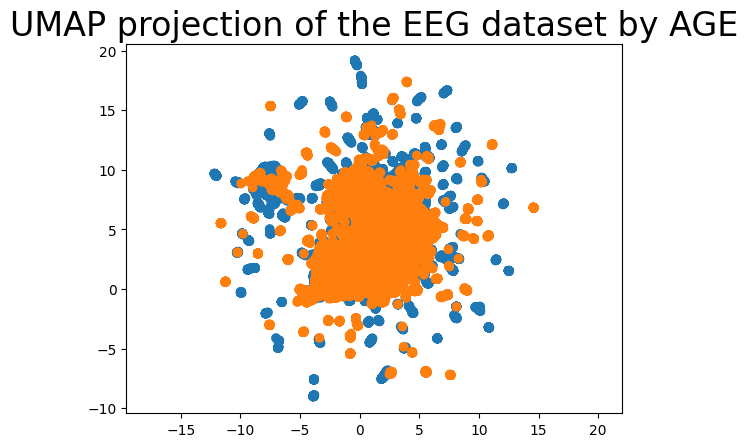

In [ ]:
age_dict = dict()
for val, key in enumerate(y_age.unique()):
  age_dict[key] = val

# sex_dict = {1: 1, }

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x]
      #  for x in y_sex
       for x in y_age.map(age_dict)
      ]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the EEG dataset by AGE', fontsize=24);